In [1]:
from Annau2022.models import generator, critic
from Annau2022.SRModel import SRModelData, SuperResolver
from Annau2022.RAPSD import compute_rapsd
from Annau2022.progress_bar import progress_bar

import torch
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    'mathtext.default': 'regular',
    'text.latex.preamble': r'\usepackage{mathrsfs}'
    })

In [19]:
lr_wrf_path  = "/workspace/Annau2022/data/idealized_data/wrf/"
lr_era_path  = "/workspace/Annau2022/data/idealized_data/era/"
lr_nfs_path  = "/workspace/Annau2022/data/fs_data/"

model_list = [
    SRModelData(region="southeast", sr_model_name="NFS", generator_param_dim=(16, 128, 7, 2), exp_id="feda42500d2b45549be96f1bf62b0b03", data_path=lr_nfs_path),
    SRModelData(region="southeast", sr_model_name="wrf_cov", generator_param_dim=(16, 128, 2, 2), exp_id="6169bc060dc9465493fd3acab7477c45", data_path=lr_wrf_path),
    SRModelData(region="southeast", sr_model_name="era_cov", generator_param_dim=(16, 128, 2, 2), exp_id="663f3525ea1f4b258b822d5968e27ad0", data_path=lr_era_path),
    
    SRModelData(region="central", sr_model_name="NFS", generator_param_dim=(16, 128, 7, 2), exp_id="0c5ee480663f4f9eb7200f8879aa1244", data_path=lr_nfs_path),
    SRModelData(region="central", sr_model_name="wrf_cov", generator_param_dim=(16, 128, 2, 2), exp_id="ecb730e5079244c88a2843ef159a4c53", data_path=lr_wrf_path),
    SRModelData(region="central", sr_model_name="era_cov", generator_param_dim=(16, 128, 2, 2), exp_id="77230ef31f7e4c738ece08a41d7c3543", data_path=lr_era_path),

    SRModelData(region="west", sr_model_name="NFS", generator_param_dim=(16, 128, 7, 2), exp_id="db9f0fae83c949eaad5d1176a43dae47", data_path=lr_nfs_path),
    SRModelData(region="west", sr_model_name="wrf_cov", generator_param_dim=(16, 128, 2, 2), exp_id="14b60d24b1634096b01734e9544ce08f", data_path=lr_wrf_path),
    SRModelData(region="west", sr_model_name="era_cov", generator_param_dim=(16, 128, 2, 2), exp_id="e047612597704ab38f2cc9c9aa4ec95f", data_path=lr_era_path),
]

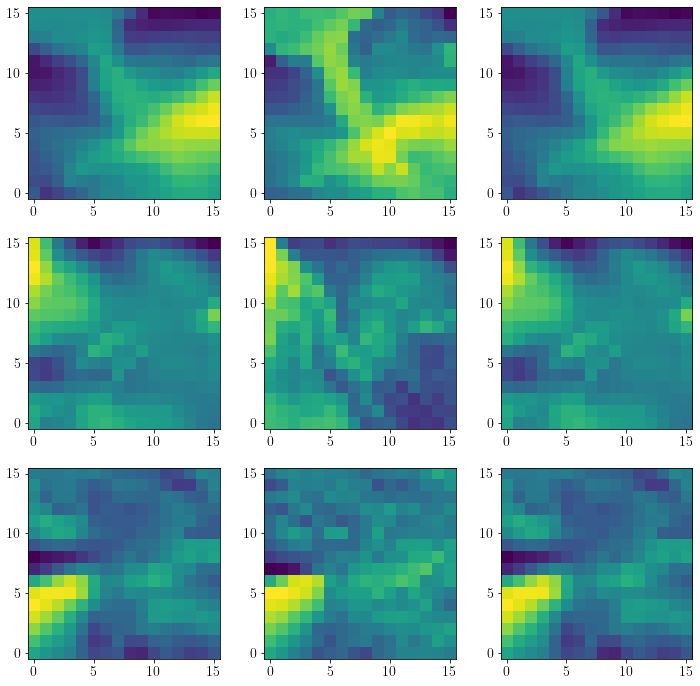

In [20]:
import matplotlib.pyplot as plt
rapsd = {"southeast":{}, "central":{}, "west":{}}
ground_truth = {"southeast":{}, "central":{}, "west":{}}
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for idx, (a, model) in enumerate(zip(ax.flat, model_list)):
    progress_bar(idx, len(model_list))

    lr, hr = model.load_test()
    generator = model.load_generator()
    sr = SuperResolver(region=model.region, lr=lr, hr=hr, model=generator)
    # a.imshow(next(sr.super_resolve())[0,0,:,:].cpu().detach().numpy(), origin="lower")
    a.imshow(lr[0,0,:,:].cpu().detach().numpy(), origin="lower")
    rapsd[model.region][model.sr_model_name] = compute_rapsd(sr.super_resolve())
    rapsd[model.region][model.sr_model_name]["ground_truth"]  = compute_rapsd(sr.ground_truth())


In [21]:
# rapsd[model.region][model.sr_model_name]["ground_truth"]


In [22]:
ground_truth.keys()

dict_keys(['southeast', 'central', 'west'])

In [23]:
k = rapsd["southeast"]["wrf_cov"]["k"]

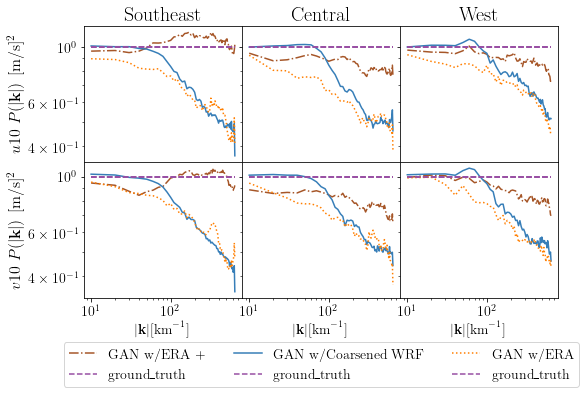

In [24]:
markermap = {
    "wrf_cov": "-",
    "era_cov": ":",
    "NFS": "-.",
    "ground_truth": "--"
}

colormap = {
    "wrf_cov": '#377eb8',
    "era_cov": '#ff7f00',
    "NFS": '#a65628',
    "ground_truth": '#984ea3'
}

titlemap = {
    "wrf_cov": "GAN w/Coarsened WRF",
    "era_cov": "GAN w/ERA",
    "NFS": "GAN w/ERA +",
    "ground_truth": "WRF"
}

var_ref = {"u10": 0, "v10": 0}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8.5, 5), sharey='row', sharex='col')
for j, region in enumerate(rapsd):
    for sr_model in rapsd[region]:
        rapsd[region][sr_model].pop("k") if "k" in rapsd[region][sr_model] else None
        for i, var in enumerate(var_ref):
            axes[i, j].loglog(
                10*k,
                rapsd[region][sr_model][var]/rapsd[region][sr_model]["ground_truth"][var],
                label=titlemap[sr_model],
                color=colormap[sr_model],
                linestyle = markermap[sr_model]
            )

            axes[i, j].loglog(
                10*k,
                rapsd[region][sr_model]["ground_truth"][var]/rapsd[region][sr_model]["ground_truth"][var],
                label="ground_truth",
                color=colormap["ground_truth"],
                linestyle = markermap["ground_truth"]
            )

            axes[i, 0].set_ylabel(fr"${var}$ "+r"$P(|\mathbf{k}|)$"+r" [m/s]$^2$", fontsize=16)
    axes[-1, j].set_xlabel(r"$|\mathbf{k}| [\textnormal{km}^{-1}]$")
    axes[0, j].set_title(region.capitalize(), fontsize=20)

axes[1, 1].legend(ncol=3, frameon=True, bbox_to_anchor=(0.5023, -0.49), loc='center', fontsize=14)
for ax in axes.flat:
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)


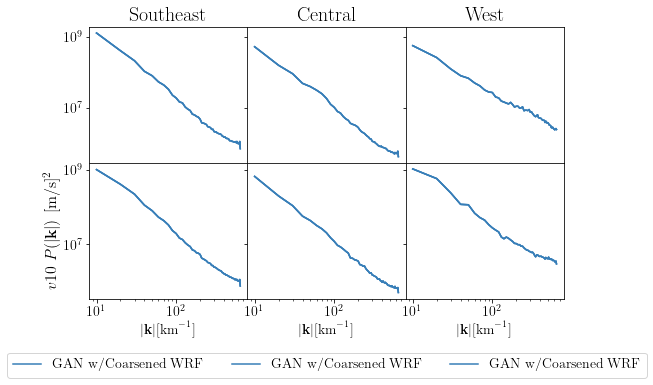

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8.5, 5), sharey='row', sharex='col')
for j, region in enumerate(rapsd):
    for sr_model in rapsd[region]:
        rapsd[region][sr_model].pop("k") if "k" in rapsd[region][sr_model] else None
        for i, var in enumerate(rapsd[region][sr_model]):
            # axes[i, j].loglog(
            #     10*k,
            #     ground_truth[region][var],
            #     label=titlemap[sr_model],
            #     color=colormap[sr_model],
            #     linestyle = markermap[sr_model]
            # )
            sr_model = "wrf_cov"
            axes[i, j].loglog(
                10*k,
                rapsd[region][sr_model][var],#/ground_truth[region][var],
                label=titlemap[sr_model],
                color=colormap[sr_model],
                linestyle = markermap[sr_model]
            )

    axes[i, 0].set_ylabel(fr"${var}$ "+r"$P(|\mathbf{k}|)$"+r" [m/s]$^2$", fontsize=16)
    axes[-1, j].set_xlabel(r"$|\mathbf{k}| [\textnormal{km}^{-1}]$")
    axes[0, j].set_title(region.capitalize(), fontsize=20)

axes[1, 1].legend(ncol=3, frameon=True, bbox_to_anchor=(0.5023, -0.49), loc='center', fontsize=14)
for ax in axes.flat:
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)